In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [3]:
# Load your data
# Replace 'your_dataset.csv' with the name of your dataset file
data = pd.read_csv('kurla_cleaned.csv', parse_dates=['date'], index_col='date')

In [17]:
# # Select the last month of data for plotting
# data_last_month = data.loc['2022-02-01':'2022-02-28']

In [4]:
# Preprocess data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))


In [5]:
# Split data into training and test sets
train_size = int(len(scaled_data) * 0.90)
train, test = scaled_data[:train_size], scaled_data[train_size:]


In [6]:
# Function to create input-output pairs for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [7]:
# Create input-output pairs for training and test sets
look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [8]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [9]:
# Create LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)



Epoch 1/10
247/247 - 2s - loss: 1.9032e-04 - val_loss: 5.7830e-05 - 2s/epoch - 10ms/step
Epoch 2/10
247/247 - 2s - loss: 1.0137e-04 - val_loss: 2.6242e-05 - 2s/epoch - 10ms/step
Epoch 3/10
247/247 - 3s - loss: 1.8427e-05 - val_loss: 1.8236e-05 - 3s/epoch - 10ms/step
Epoch 4/10
247/247 - 3s - loss: 1.1680e-06 - val_loss: 2.0106e-05 - 3s/epoch - 10ms/step
Epoch 5/10
247/247 - 3s - loss: 1.2133e-06 - val_loss: 2.1483e-05 - 3s/epoch - 10ms/step
Epoch 6/10
247/247 - 3s - loss: 1.0229e-06 - val_loss: 2.5958e-05 - 3s/epoch - 11ms/step
Epoch 7/10
247/247 - 2s - loss: 6.1929e-06 - val_loss: 3.3835e-04 - 2s/epoch - 10ms/step
Epoch 8/10
247/247 - 3s - loss: 8.5186e-07 - val_loss: 8.2957e-06 - 3s/epoch - 11ms/step
Epoch 9/10
247/247 - 2s - loss: 2.5287e-05 - val_loss: 3.4007e-06 - 2s/epoch - 10ms/step
Epoch 10/10
247/247 - 3s - loss: 3.9270e-05 - val_loss: 1.5410e-06 - 3s/epoch - 11ms/step


In [12]:
# Evaluate the model
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Score: {train_score:.5f} MSE ({np.sqrt(train_score):.5f} RMSE)')
print(f'Test Score: {test_score:.5f} MSE ({np.sqrt(test_score):.5f} RMSE)')

Train Score: 0.00007 MSE (0.00816 RMSE)
Test Score: 0.00000 MSE (0.00124 RMSE)


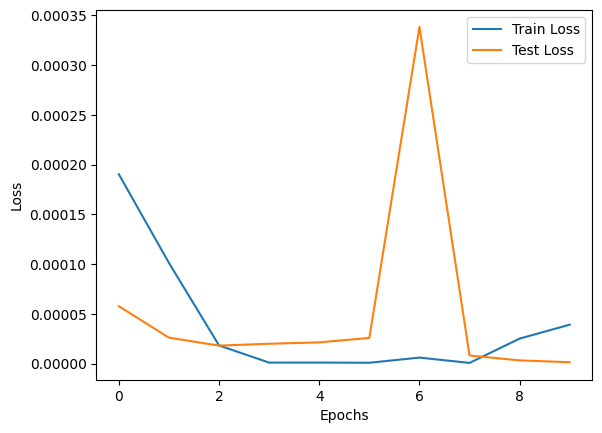

In [13]:
# Plot accuracy improvement during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Predict values for the last month
predictions = model.predict(X_test[-720:])
predictions = scaler.inverse_transform(predictions)

23/23 [==============================] - 0s 3ms/step


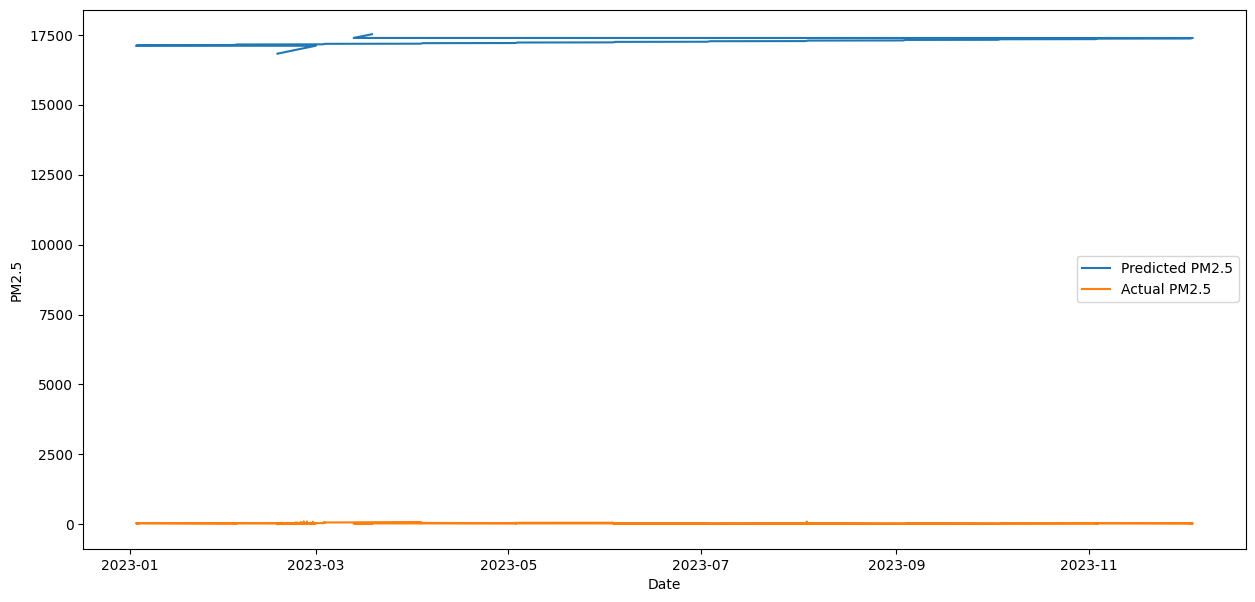

In [18]:
# Plot the predicted values
last_month = data.iloc[-720:].index
plt.figure(figsize=(15, 7))
plt.plot(last_month, predictions, label='Predicted PM2.5')
plt.plot(last_month, data.loc[last_month, 'PM2.5'], label='Actual PM2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()